In [ ]:
import re
import os
import jax
import pickle
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["lines.linewidth"] = 2

In [8]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    
    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)
    
    lbound = mean_sim - 1 * std_sim
    ubound = mean_sim + 1 * std_sim
    
    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)


def get_subtree(tree, key):
    return jax.tree_map(lambda x: x[key], tree, is_leaf=lambda x: key in x)


def extract_data(files, base_path):
    regexp = re.compile("rank([0-9]+).pkl")
    data_all = {}
    for file in files:
        m = regexp.findall(file)
        if len(m) == 0:
            continue
            rank = 50
        else:
            rank = int(m[0])

        file_path = os.path.join(base_path, file)
        with open(file_path, "rb") as f:
            data = pickle.load(f)
        data_all[rank] = data
    return data_all



def extract_filenames(dataset, base_path):
    files = os.listdir(path)
    files_target = [file for file in files if (dataset in file) and ("pass" not in file)]
    return files_target


def build_df_summary(data, dataset_name):
    """
    Summary over the last-observed value
    """
    agent_last = jax.tree_map(lambda x: x[:, -1], data)
    df_summary = []
    for key in agent_last:
        piece = pd.DataFrame(agent_last[key])

        if key != 1:
            drop_cols = ["fdekf", "vdekf"]
            piece = piece.drop(drop_cols, axis=1)
        if key != 2:
            drop_cols = ["fcekf"]
            piece = piece.drop(drop_cols, axis=1)


        piece = piece.melt()
        piece["rank"] = key
        df_summary.append(piece)
    df_summary = pd.concat(df_summary).dropna(axis=0)
    df_summary = df_summary.query("variable != 'lofi_orth'")

    df_summary.loc[df_summary["variable"] == "fcekf", "rank"] = "full"
    df_summary.loc[df_summary["variable"] == "fdekf", "rank"] = 0
    df_summary.loc[df_summary["variable"] == "vdekf", "rank"] = 0
    df_summary = df_summary.assign(dataset=dataset_name)
    return df_summary

In [9]:
path = "./output/cross-validation"

In [10]:
order_cols = ["fcekf", "fdekf", "vdekf", "lofi", "lofi_diag", "lrvga", "sgd-rb"]

In [11]:
all_files = os.listdir(path)
datasets = list(set([f.split("_")[0].split(".")[0] for f in all_files]))

void_datasets = ["protein-tertiary-structure"]
datasets = [d for d in datasets if d not in void_datasets]
sorted(datasets)

['bostonHousing',
 'concrete',
 'energy',
 'kin8nm',
 'naval-propulsion-plant',
 'power-plant',
 'wine-quality-red',
 'yacht']

In [12]:
dataset = "energy"
files_target = extract_filenames(dataset, path)
sorted(files_target)

['energy.pkl',
 'energy_rank01.pkl',
 'energy_rank02.pkl',
 'energy_rank05.pkl',
 'energy_rank10.pkl',
 'energy_rank20.pkl',
 'energy_rank50.pkl']

In [13]:
data_dataset = extract_data(files_target, path)
data_test = get_subtree(data_dataset, "test")
df_summary = build_df_summary(data_test, dataset)

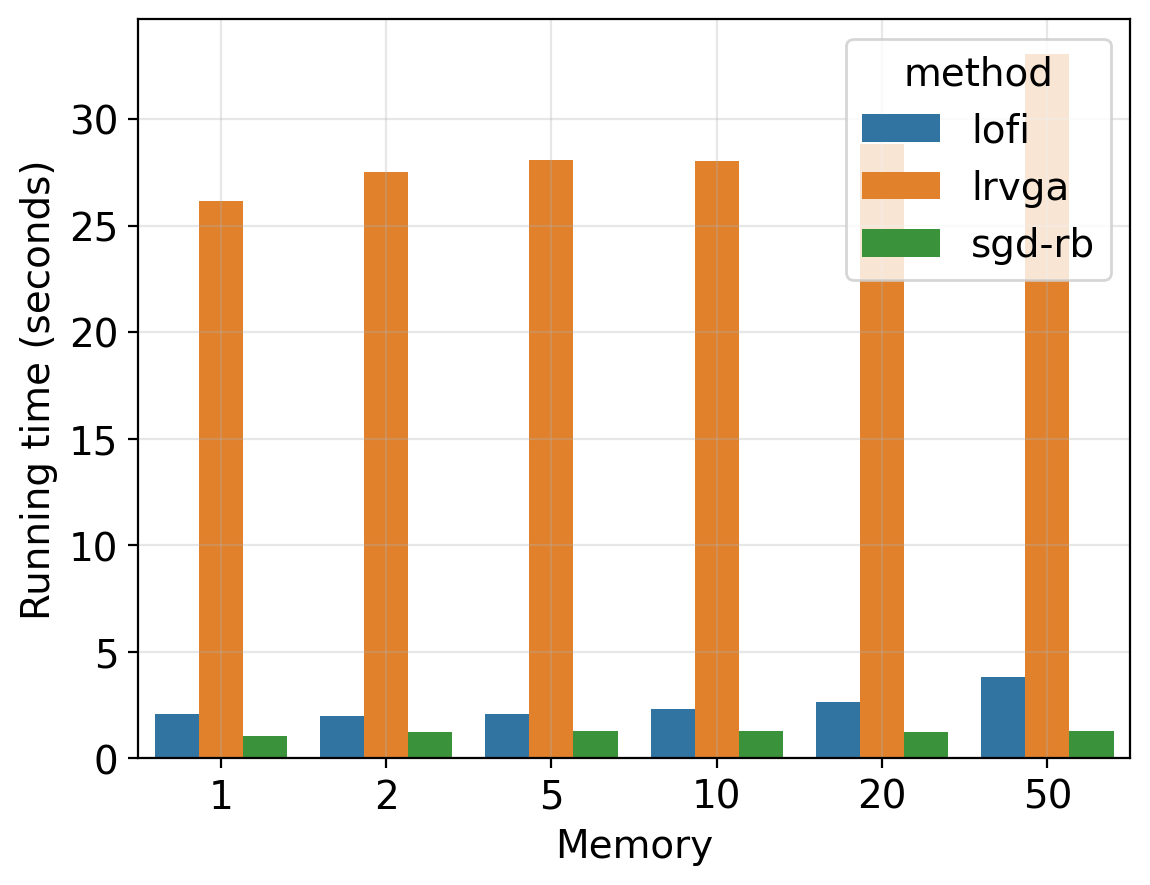

In [14]:
target_agents_time = ["lofi", "lrvga", "sgd-rb"]
data_time = pd.DataFrame(get_subtree(data_dataset, "running_time")).astype(float).T
data_time = data_time[target_agents_time]
data_time.index.name = "rank"
data_time = data_time.reset_index().melt(id_vars="rank", var_name="method")
sns.barplot(data_time, x="rank", y="value", hue="method")
plt.ylabel("Running time (seconds)")
plt.xlabel("Memory")
plt.grid(alpha=0.3)
plt.savefig(f"./output/images/{dataset}-running-time.pdf")

In [15]:
colors = {
    'fcekf': np.array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
    'fdekf': np.array([1.        , 0.49803922, 0.05490196, 1.        ]),
    'vdekf': np.array([0.17254902, 0.62745098, 0.17254902, 1.        ]),
    'lofi': np.array([0.83921569, 0.15294118, 0.15686275, 1.        ]),
    'lofi_orth': np.array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
    'lrvga': np.array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
    'sgd-rb': np.array([0.89019608, 0.46666667, 0.76078431, 1.        ])
}

In [16]:
methods = df_summary.variable.unique()
colors = plt.cm.Dark2(np.linspace(0, len(methods)))
colors = {
    method: color
    for method, color in zip(methods, colors)
}

In [17]:
methods

array(['fdekf', 'lofi', 'lofi_diag', 'lrvga', 'sgd-rb', 'vdekf', 'fcekf'],
      dtype=object)

(0.593106722831726, 5.0)

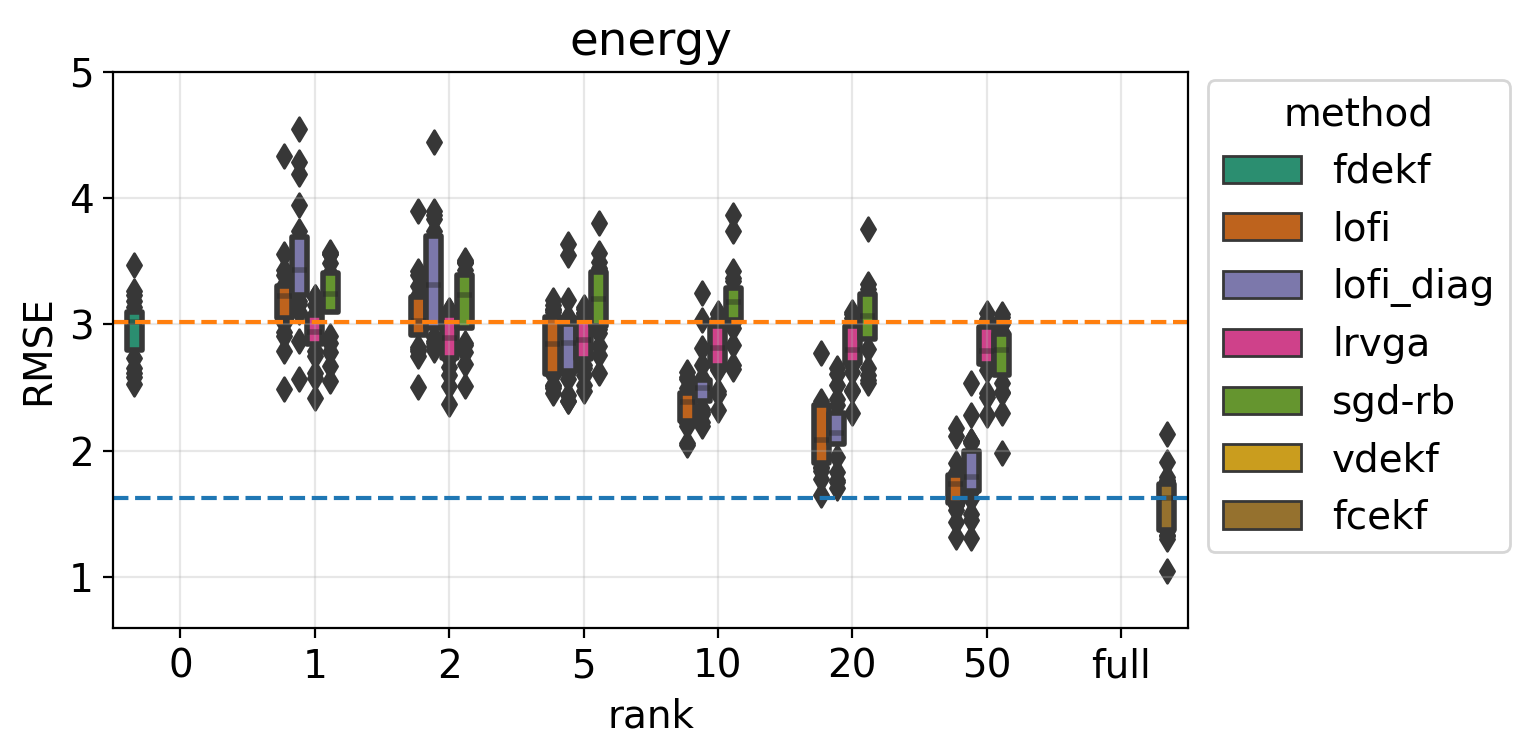

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))

cols_sort = [0, 1, 2, 5, 10, 20, 50, "full"]
void = ["fdekf", "fcekf", "vdekf"]
lbound = df_summary.query("variable == 'fcekf'")["value"].median()
ubound = df_summary.query("variable == 'fdekf'")["value"].median()


sns.boxenplot(hue="variable", y="value", x="rank", data=df_summary, order=cols_sort, palette=colors)
plt.axhline(y=ubound, c="tab:orange", linestyle="--", linewidth=1.5)
plt.axhline(y=lbound, c="tab:blue", linestyle="--", linewidth=1.5)

plt.legend(loc="upper left", title="method", bbox_to_anchor=(1, 1.02))
plt.ylabel("RMSE")
plt.xlabel("rank")
plt.title(dataset)
plt.grid(alpha=0.3)
plt.tight_layout()
ymin, _ = plt.ylim()
plt.ylim(ymin, 5)
# plt.savefig(f"./output/images/{dataset}-rank-comparison.pdf")

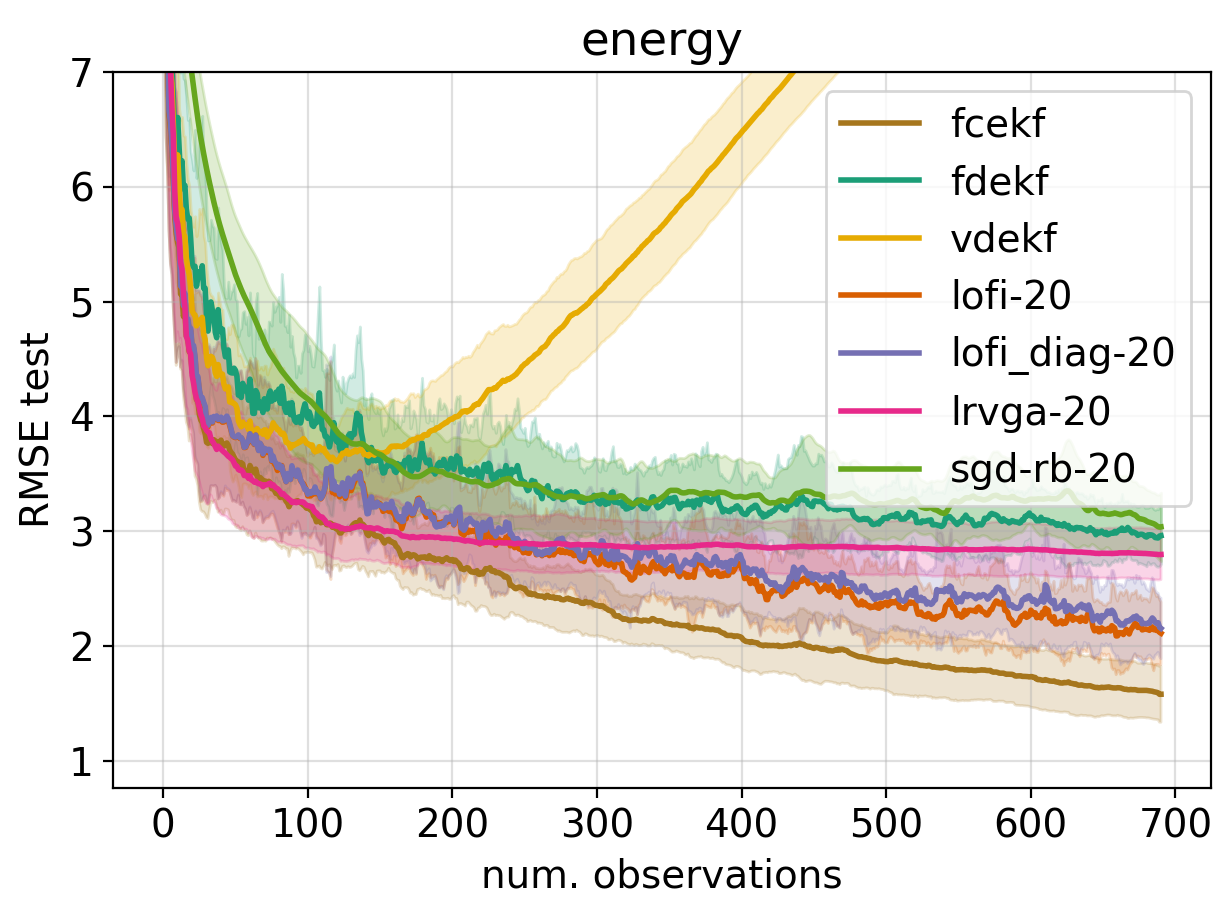

In [19]:
fig, ax = plt.subplots()

rank = 20
for method in order_cols:
    color = colors[method]
    
    label = method
    
    target_methods = ["lofi_diag", "lofi", "lrvga", "sgd-rb"]
    if method in target_methods:
        label = f"{method}-{rank}"
    
    if method == "vdekf":
        test_res = pd.DataFrame(data_test[1][method].T)
    else:
        test_res = pd.DataFrame(data_test[rank][method].T)
    plot_bounds(test_res, ax, color, label, rolling=1)
plt.legend()
plt.ylabel(f"RMSE test")
plt.xlabel("num. observations")
plt.title(dataset)
plt.grid(alpha=0.4)

ymin, _ = plt.ylim()
plt.ylim(ymin, 7)

name_figure = f"{dataset}-rank{rank:02}-test-set.pdf"
plt.tight_layout()

# plt.savefig(f"./output/images/{name_figure}")

## Plot for single dataset, as a function of the rank

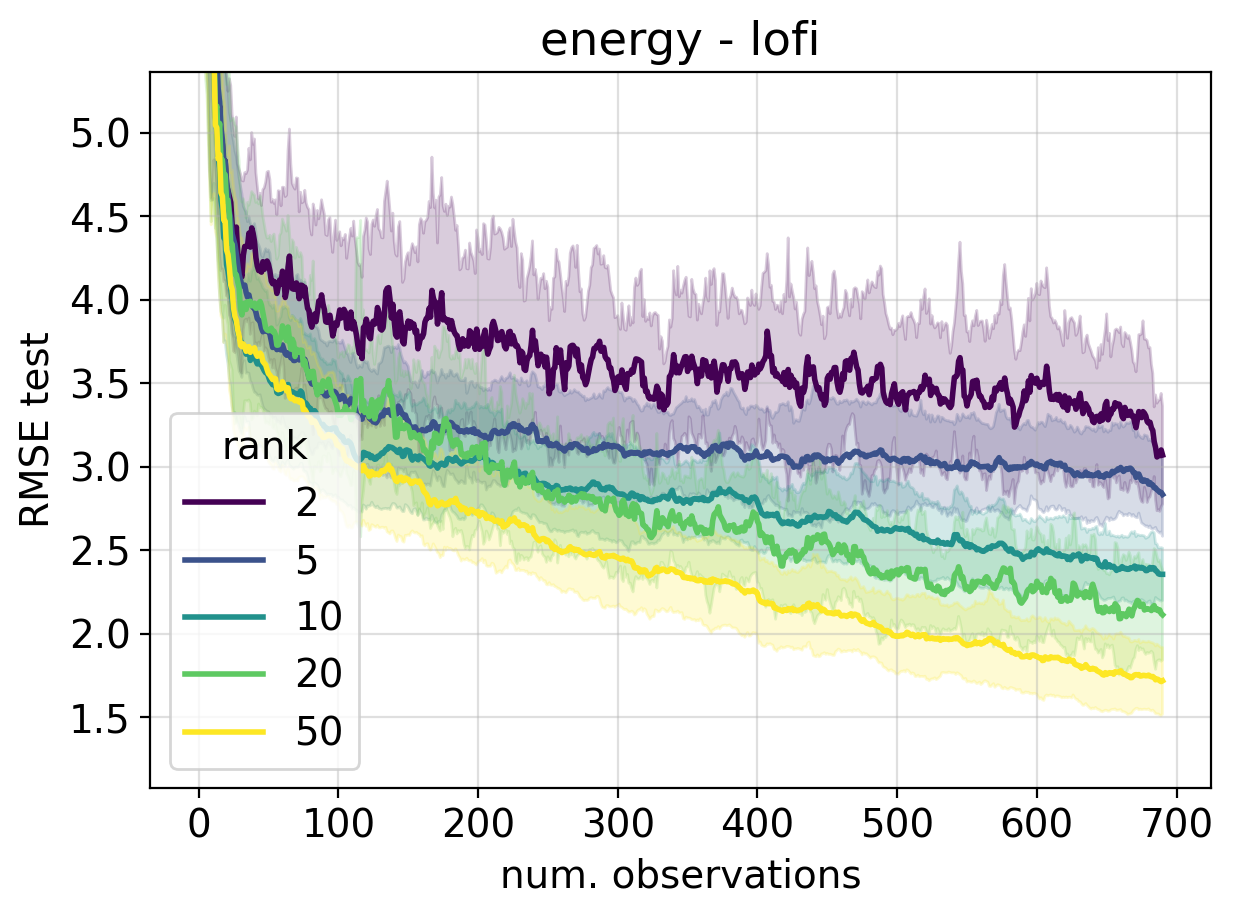

In [20]:
fig, ax = plt.subplots()

ranks = [2, 5, 10, 20, 50]
# ranks = [2, 5, 20]
cmaps = plt.cm.viridis(np.linspace(0, 1, len(ranks)))
method = "lofi"
for color, rank in zip(cmaps, ranks):
    label = rank
    # color = cmaps[rank]
    test_res = pd.DataFrame(data_test[rank][method].T)
    plot_bounds(test_res, ax, color, label, rolling=1)
plt.legend(title="rank", loc="lower left")
plt.ylabel(f"RMSE test")

plt.xlabel("num. observations")
plt.grid(alpha=0.4)
plt.title(f"{dataset} - {method}")
ymin, _  = plt.ylim()
plt.ylim(ymin, 5 * ymin)
name_figure = f"{dataset}-all-ranks-test-set.pdf"
plt.tight_layout()
plt.savefig(f"./output/images/{name_figure}")

## Tables!

In [22]:
void_datasets = ["protein-tertiary-structure"]

In [23]:
# path = "./output/cross-validation"
path = "./output/cross-validation"

In [24]:
df_summaries = []
for dataset in datasets:
    files_target = extract_filenames(dataset, path)
    data_dataset = extract_data(files_target, path)
    data_test = get_subtree(data_dataset, "test")
    df_summary = build_df_summary(data_test, dataset)
    df_summaries.append(df_summary)
df_summaries = pd.concat(df_summaries, axis=0)

## LoFi outputs

In [25]:
def format_entry(entry):
    mean = entry.mean()
    std = entry.std()
    label = rf"${mean:0.2f} \pm {std:0.2f}$"
    return label

In [26]:
aggfunc = format_entry
aggfunc = "mean"

dfsumm_lofi = (
    df_summaries
    .query("variable=='lofi'")
    # Replace with format_entry for latex output
    .pivot_table(index="dataset", columns="rank", values="value", aggfunc=aggfunc)
)
dfsumm_lofi.T

dataset,bostonHousing,concrete,energy,kin8nm,naval-propulsion-plant,power-plant,wine-quality-red,yacht
rank,,,,,,,,
1,5.080718,8.836946,3.213861,0.140268,0.006876,4.364764,0.666648,5.760225
2,4.383880,8.173999,3.070564,0.263701,0.002023,4.326953,0.658951,5.978009
5,4.102889,7.766768,2.834397,0.150496,0.001273,4.244723,0.653073,5.507314
10,5.116864,7.268073,2.356136,0.120652,0.001191,4.202857,0.650432,4.658266
20,4.876719,6.922862,2.113637,0.113437,0.002451,4.228817,0.647944,4.732761
50,4.843648,6.651085,1.718370,0.103986,0.015791,4.201570,0.686294,2.308869


## LoFi diag

In [27]:
# aggfunc = format_entry
aggfunc = "mean"

dfsumm_lofi = (
    df_summaries
    .query("variable=='lofi_diag'")
    .pivot_table(index="dataset", columns="rank", values="value", aggfunc=aggfunc)
)
dfsumm_lofi.T

dataset,bostonHousing,concrete,energy,kin8nm,naval-propulsion-plant,power-plant,wine-quality-red,yacht
rank,,,,,,,,
1,5.080718,9.118502,3.497588,0.141992,0.010111,5.007213,0.690240,5.913607
2,4.997956,8.536203,3.341994,0.147776,0.001864,4.585384,0.726085,5.652786
5,4.753259,8.459824,2.873651,0.129425,0.001415,4.555909,0.739751,4.299987
10,4.769196,7.326795,2.530251,0.143918,0.001194,4.371668,0.715969,4.660659
20,4.876719,8.028241,2.155609,0.136801,0.000996,4.414195,0.657744,2.366949
50,4.843648,6.696385,1.841023,0.107981,0.000972,4.299555,0.642192,4.853773


In [28]:
# aggfunc = format_entry
aggfunc = "mean"

dfsumm_lofi = (
    df_summaries
    .query("variable=='lofi_diag'")
    .pivot_table(index="dataset", columns="rank", values="value", aggfunc=aggfunc)
)
dfsumm_lofi.T

dataset,bostonHousing,concrete,energy,kin8nm,naval-propulsion-plant,power-plant,wine-quality-red,yacht
rank,,,,,,,,
1,5.080718,9.118502,3.497588,0.141992,0.010111,5.007213,0.690240,5.913607
2,4.997956,8.536203,3.341994,0.147776,0.001864,4.585384,0.726085,5.652786
5,4.753259,8.459824,2.873651,0.129425,0.001415,4.555909,0.739751,4.299987
10,4.769196,7.326795,2.530251,0.143918,0.001194,4.371668,0.715969,4.660659
20,4.876719,8.028241,2.155609,0.136801,0.000996,4.414195,0.657744,2.366949
50,4.843648,6.696385,1.841023,0.107981,0.000972,4.299555,0.642192,4.853773


## L-RVGA outputs

In [29]:
dfsumm_lrvga = (
    df_summaries
    .query("variable=='lrvga'")
    .pivot_table(index="dataset", columns="rank", values="value", aggfunc="mean")
)

dfsumm_lrvga

rank,1,2,5,10,20,50
dataset,,,,,,
bostonHousing,4.135913,3.884005,3.710735,3.623823,3.570921,3.519924
concrete,7.453021,7.411405,6.976663,7.279297,6.734220,6.703252
energy,2.924246,2.872354,2.860740,2.800892,2.798979,2.785239
kin8nm,0.135370,0.138369,0.126306,0.119086,0.114295,0.113341
naval-propulsion-plant,NaN,0.003846,0.002714,0.002100,0.001695,0.001199
power-plant,4.254991,4.243989,4.229290,4.217532,4.242579,4.213123
wine-quality-red,0.651668,0.651344,0.650652,0.651245,0.644712,0.640937
yacht,5.055619,4.229970,3.667035,3.387812,2.761082,3.326556


## SGD w/ replay buffer

In [30]:
aggfunc = "mean"

dfsumm_sgd = (
    df_summaries
    .query("variable=='sgd-rb'")
    .pivot_table(index="dataset", columns="rank", values="value", aggfunc=aggfunc)
)

dfsumm_sgd

rank,1,2,5,10,20,50
dataset,,,,,,
bostonHousing,4.442287,4.311107,4.291359,4.414332,4.385984,4.192142
concrete,9.616455,9.133688,8.717462,8.460921,8.261668,7.709388
energy,3.194648,3.161685,3.183270,3.181982,3.039046,2.732298
kin8nm,0.155616,0.147096,0.136574,0.131691,0.124589,0.119109
naval-propulsion-plant,0.009234,0.008208,0.005288,0.001844,0.000878,0.000401
power-plant,4.405602,4.499103,4.723950,4.814272,4.772392,4.805251
wine-quality-red,0.662220,0.667178,0.681084,0.696468,0.717709,0.762237
yacht,9.839925,9.033509,8.359159,7.918941,7.418996,6.624576


## xKF

In [31]:
target_vars = ["fcekf", "fdekf", "vdekf"]
dfsumm_xkf = (
    df_summaries
    .query("variable in @target_vars")
    # Replace (aggfunc) with format_entry for latex output
    .pivot_table(index="dataset", columns="variable", values="value", aggfunc="mean")
)

dfsumm_xkf

variable,fcekf,fdekf,vdekf
dataset,,,
bostonHousing,4.042458,5.234724,9.033447
concrete,6.448200,8.597416,16.345562
energy,1.582862,2.962508,9.441345
kin8nm,0.100185,0.120360,0.141021
naval-propulsion-plant,0.000575,0.012058,0.010842
power-plant,4.126744,4.238136,4.250752
wine-quality-red,0.657284,0.820677,0.658894
yacht,3.144549,5.132223,5.599589


## Relative performance to FC-EKF

In [33]:
rank = 10
df_rank = [
    dfsumm_xkf["fcekf"], dfsumm_xkf["fdekf"], dfsumm_xkf["vdekf"],
    dfsumm_lofi[rank], dfsumm_lrvga[rank], dfsumm_sgd[rank]
]
df_rank = pd.concat(df_rank, axis=1)

columns = ["fcekf", "fdekf", "vdekf", "lofi", "lrvga", "sgd-rb"]
# ranks = ["Rank 0", "Rank 0", f"Rank {rank}", f"Rank {rank}", f"Rank {rank}"]
# columns = list(zip(ranks, columns))
# columns = pd.MultiIndex.from_tuples(columns)

df_rank.columns = columns

# df_rank = dfsumm_xkf["fcekf"].values[:, None] -  df_rank

### Standardise rmse

In [34]:
from rebayes.utils import uci_uncertainty_data

In [ ]:
dataset_name = "energy"

coefs_all = {}
for dataset_name in datasets:
    if dataset_name in void_datasets:
        continue
    
    path = path = (
        "/home/gerardoduran/documents/external"
        "/DropoutUncertaintyExps/UCI_Datasets/"
        f"{dataset_name}/"
        "data"
    )

    *_, coefs = uci_uncertainty_data.load_folds_data(path)
    coefs_all[dataset_name] = coefs

coefs_all = jax.tree_map(lambda x: x.mean().item(), coefs_all)
coefs_all = pd.DataFrame.from_dict(coefs_all, orient="index")

In [ ]:
df_rank_std = df_rank.divide(coefs_all["ystd"], axis="rows")
df_rank_std = -df_rank_std.drop("fcekf", axis=1).sub(df_rank_std["fcekf"], axis="rows")

columns = ["fdekf", "vdekf", "lofi", "lrvga", "sgd-rb"]
ranks = ["Rank 0", "Rank 0", f"Rank {rank}", f"Rank {rank}", f"Rank {rank}"]
columns = list(zip(ranks, columns))
columns = pd.MultiIndex.from_tuples(columns)

df_rank_std.columns = columns

In [ ]:
print(df_rank_std.applymap(lambda x: f"${x:0.2f}$").style.to_latex())

In [ ]:
latex_table = (
    pd.io.formats.style.Styler(df_rank_std, precision=2)
    .highlight_max(axis=1, props="font-weight: bold;")
)

latex_table

## UCI database description

In [33]:
def count_rows(filename):
    with open(filename) as f:
        r = f.read()
        lines = r.strip().split("\n")
    return len(lines)

In [34]:
dataset_summary = []
for dataset_name in datasets:
        path = (
        "/home/gerardoduran/documents/external"
        "/DropoutUncertaintyExps/UCI_Datasets/"
        )
        
        file_data = os.path.join (path, dataset_name, "data")
        file_features = os.path.join(file_data, "index_features.txt")
        file_training_ix = os.path.join(file_data, "index_train_0.txt")
        file_test_ix = os.path.join(file_data, "index_test_0.txt")
        
        nfeatures = count_rows(file_features)
        ntrain = count_rows(file_training_ix)
        ntest = count_rows(file_test_ix)
        
        dataset_summary.append({
            "dataset": dataset_name,
            "num_features": nfeatures,
            "num_train": ntrain,
            "num_test": ntest,
        })
        
dataset_summary = pd.DataFrame(dataset_summary).set_index("dataset")

dataset_summary["num_total"] = dataset_summary["num_train"] + dataset_summary["num_test"]
dataset_summary["num_parameters"] = dataset_summary["num_features"] * 50 + 50 * 1 + 50 + 1

In [36]:
dataset_summary

,num_features,num_train,num_test,num_total,num_parameters
dataset,,,,,
yacht,6,277,31,308,401
kin8nm,8,7373,819,8192,501
bostonHousing,13,455,51,506,751
naval-propulsion-plant,16,10741,1193,11934,901
wine-quality-red,11,1439,160,1599,651
power-plant,4,8611,957,9568,301
concrete,8,927,103,1030,501
energy,8,691,77,768,501


In [ ]:
print(dataset_summary.style.to_latex())